In [2]:
import os
IMAGES_PATH = "/home/luminoso/thesis/gjc-ml-2018mar/"
def save_fig(fig_id, tight_layout=True, fig_extension="pdf", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [3]:
# Load serialized dataframe

import pickle
import pandas as pd

# [86400, 21600, 7200, 3600, 900]

file = "df_900_0.3_v3.raw"

df = pickle.load(open(file, 'rb'))  # type: pd.DataFrame


In [4]:
df.shape

(55484, 64)

In [5]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse
import numpy as np


class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.

    The input to this transformer should be an array-like of integers or
    strings, denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot (aka one-of-K or dummy)
    encoding scheme (``encoding='onehot'``, the default) or converted
    to ordinal integers (``encoding='ordinal'``).

    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.

    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.

    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):

        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.

    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:

        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories must be sorted and should not mix
          strings and numeric values.

        The used categories can be found in the ``categories_`` attribute.

    dtype : number type, default np.float64
        Desired dtype of output.

    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros. In the inverse transform, an unknown category
        will be denoted as None.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.

    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting
        (in order corresponding with output of ``transform``).

    Examples
    --------
    Given a dataset with two features, we let the encoder find the unique
    values per feature and transform the data to a binary one-hot encoding.

    >>> from sklearn.preprocessing import CategoricalEncoder
    >>> enc = CategoricalEncoder(handle_unknown='ignore')
    >>> X = [['Male', 1], ['Female', 3], ['Female', 2]]
    >>> enc.fit(X)
    ... # doctest: +ELLIPSIS
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    >>> enc.categories_
    [array(['Female', 'Male'], dtype=object), array([1, 2, 3], dtype=object)]
    >>> enc.transform([['Female', 1], ['Male', 4]]).toarray()
    array([[ 1.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  0.,  0.,  0.]])
    >>> enc.inverse_transform([[0, 1, 1, 0, 0], [0, 0, 0, 1, 0]])
    array([['Male', 1],
           [None, 2]], dtype=object)

    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.

        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to determine the categories of each feature.

        Returns
        -------
        self

        """
        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        if self.categories != 'auto':
            for cats in self.categories:
                if not np.all(np.sort(cats) == np.array(cats)):
                    raise ValueError("Unsorted categories are not yet "
                                     "supported")

        X_temp = check_array(X, dtype=None)
        if not hasattr(X, 'dtype') and np.issubdtype(X_temp.dtype, np.str_):
            X = check_array(X, dtype=np.object)
        else:
            X = X_temp

        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                if self.handle_unknown == 'error':
                    valid_mask = np.in1d(Xi, self.categories[i])
                    if not np.all(valid_mask):
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(self.categories[i])

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using specified encoding scheme.

        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.

        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.

        """
        X_temp = check_array(X, dtype=None)
        if not hasattr(X, 'dtype') and np.issubdtype(X_temp.dtype, np.str_):
            X = check_array(X, dtype=np.object)
        else:
            X = X_temp

        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            Xi = X[:, i]
            valid_mask = np.in1d(Xi, self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    Xi = Xi.copy()
                    Xi[~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(Xi)

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        feature_indices = np.cumsum(n_values)

        indices = (X_int + feature_indices[:-1]).ravel()[mask]
        indptr = X_mask.sum(axis=1).cumsum()
        indptr = np.insert(indptr, 0, 0)
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csr_matrix((data, indices, indptr),
                                shape=(n_samples, feature_indices[-1]),
                                dtype=self.dtype)
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

    def inverse_transform(self, X):
        """Convert back the data to the original representation.

        In case unknown categories are encountered (all zero's in the
        one-hot encoding), ``None`` is used to represent this category.

        Parameters
        ----------
        X : array-like or sparse matrix, shape [n_samples, n_encoded_features]
            The transformed data.

        Returns
        -------
        X_tr : array-like, shape [n_samples, n_features]
            Inverse transformed array.

        """
        check_is_fitted(self, 'categories_')
        X = check_array(X, accept_sparse='csr')

        n_samples, _ = X.shape
        n_features = len(self.categories_)
        n_transformed_features = sum([len(cats) for cats in self.categories_])

        # validate shape of passed X
        msg = ("Shape of the passed X data is not correct. Expected {0} "
               "columns, got {1}.")
        if self.encoding == 'ordinal' and X.shape[1] != n_features:
            raise ValueError(msg.format(n_features, X.shape[1]))
        elif (self.encoding.startswith('onehot')
              and X.shape[1] != n_transformed_features):
            raise ValueError(msg.format(n_transformed_features, X.shape[1]))

        # create resulting array of appropriate dtype
        dt = np.find_common_type([cat.dtype for cat in self.categories_], [])
        X_tr = np.empty((n_samples, n_features), dtype=dt)

        if self.encoding == 'ordinal':
            for i in range(n_features):
                labels = X[:, i].astype('int64')
                X_tr[:, i] = self.categories_[i][labels]

        else:  # encoding == 'onehot' / 'onehot-dense'
            j = 0
            found_unknown = {}

            for i in range(n_features):
                n_categories = len(self.categories_[i])
                sub = X[:, j:j + n_categories]

                # for sparse X argmax returns 2D matrix, ensure 1D array
                labels = np.asarray(_argmax(sub, axis=1)).flatten()
                X_tr[:, i] = self.categories_[i][labels]

                if self.handle_unknown == 'ignore':
                    # ignored unknown categories: we have a row of all zero's
                    unknown = np.asarray(sub.sum(axis=1) == 0).flatten()
                    if unknown.any():
                        found_unknown[i] = unknown

                j += n_categories

            # if ignored are found: potentially need to upcast result to
            # insert None values
            if found_unknown:
                if X_tr.dtype != object:
                    X_tr = X_tr.astype(object)

                for idx, mask in found_unknown.items():
                    X_tr[mask, idx] = None

        return X_tr

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

## Pipeline

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_attribs = list(df.drop("entity", axis=1))  # numerical attributes

cat_attribs = ["entity"]  # categorical attributes

# numerical and categorical pipelines
num_pipeline = Pipeline([
    #        ('imputer', Imputer(strategy="median")),
    #        ('attribs_adder', CombinedAttributesAdder()),
    ('selector', DataFrameSelector(num_attribs)),
    ('std_scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('cat_encoder', CategoricalEncoder(encoding="ordinal")),
])

In [8]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    #("cat_pipeline", cat_pipeline),
])


In [9]:
from sklearn.utils import shuffle
df = shuffle(df)

In [10]:
fulldata = full_pipeline.fit_transform(df)
cat_encoder = CategoricalEncoder(encoding="ordinal")
fulldata_labels = df['entity'].values.reshape(-1, 1)
fulldata_labels_ordinal = cat_encoder.fit_transform(fulldata_labels)

In [11]:
from sklearn import svm
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

algos =[ (svm.SVC(),'svm svc'), # C-Support Vector Classification.
         (svm.LinearSVC(), 'svm_linear'), # Linear Support Vector Classification.
         (svm.NuSVC(), 'nusvc'), # Nu-Support Vector Classification.
         (svm.NuSVR(), 'nusvr'), # Nu Support Vector Regression.
         (svm.SVR(),'svr'), # Epsilon-Support Vector Regression.
         (DecisionTreeClassifier(),'dtree'),
         (DecisionTreeRegressor(),'dtreerg'),
         (KNeighborsClassifier(n_neighbors=3),'near'),
         (MLPClassifier(solver='adam',
                           alpha=1e-5,
                           hidden_layer_sizes=(5, 2),
                           #random_state=1,
                           max_iter=10000,
                           learning_rate='adaptive'),'neural'),
        (KNeighborsClassifier(3),'knei_3'),
        #(GaussianProcessClassifier(1.0 * RBF(1.0)),'gaussian'),
        (RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),'randomforest'),
        (AdaBoostClassifier(),'adaboost'),
        (GaussianNB(),'gaussianNB'),
        (QuadraticDiscriminantAnalysis(),'quadratic')
]


for al in algos:
    classifier, name = al
    
    scores = cross_val_score(classifier,
                             fulldata,
                             fulldata_labels_ordinal.ravel()
                             #scoring='accuracy'
                            )

    print("Accuracy %s: %0.2f (+/- %0.4f)" % (name, scores.mean(), scores.std() * 2 * 100))

KeyboardInterrupt: 

In [ ]:
df_cat = df['entity']
df_encoded, df_categories = df_cat.factorize()

In [ ]:
df_categories

In [ ]:
#fulldata = full_pipeline.fit_transform(df)
from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder()
fulldata_labels_oneH = onehot_encoder.fit_transform(df_encoded.reshape(-1, 1))

In [ ]:
fulldata_labels_oneH

In [31]:
from sklearn import svm
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

algos =[ (svm.SVC(),'svm svc'), # C-Support Vector Classification.
         (svm.LinearSVC(), 'svm_linear'), # Linear Support Vector Classification.
         #(svm.NuSVC(), 'nusvc'), # Nu-Support Vector Classification.
         #(svm.NuSVR(), 'nusvr'), # Nu Support Vector Regression.
         (svm.SVR(),'svr'), # Epsilon-Support Vector Regression.
         (DecisionTreeClassifier(),'dtree'), # Decision Tree Classifier
         (DecisionTreeRegressor(),'dtreerg'), # Decision Trees Regressor
         (KNeighborsClassifier(n_neighbors=3),'near'), # K-nearest neighbors
         (MLPClassifier(solver='adam', # Multi-layer Perceptron classifier
                           alpha=1e-5,
                           hidden_layer_sizes=(5, 2),
                           #random_state=1,
                           max_iter=10000,
                           learning_rate='adaptive'),'neural'),
        (KNeighborsClassifier(3),'knei_3'),
        #(GaussianProcessClassifier(1.0 * RBF(1.0)),'gaussian'),
        (RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),'randomforest'), # Random Forest Classifier
        (AdaBoostClassifier(),'adaboost'), # AdaBoost Classifier
        (GaussianNB(),'gaussianNB'), # Gaussian Naive Bayes (GaussianNB)
        (QuadraticDiscriminantAnalysis(),'quadratic') # Quadratic Discriminant Analysis
]

for i in range(0,fulldata_labels_oneH.shape[1]):
    print(df_categories[i])                   
    for al in algos:
        classifier, name = al
    
        scores = cross_val_score(classifier,
                             fulldata,
                             fulldata_labels_oneH[:,i].toarray().ravel()
                             #scoring='accuracy'
                            )

        print("Accuracy %s: %0.2f (+/- %0.4f)" % (name, scores.mean(), scores.std() * 2 * 100))
    print("")

np_ubuntu.raw
Accuracy svm svc: 0.96 (+/- 0.1996)
Accuracy svm_linear: 0.96 (+/- 0.2577)
Accuracy svr: 0.75 (+/- 0.6671)
Accuracy dtree: 0.96 (+/- 0.1106)
Accuracy dtreerg: 0.76 (+/- 0.3288)
Accuracy near: 0.96 (+/- 0.4987)
Accuracy neural: 0.87 (+/- 12.2705)
Accuracy knei_3: 0.96 (+/- 0.4987)
Accuracy randomforest: 0.95 (+/- 0.1141)
Accuracy adaboost: 0.96 (+/- 0.1389)
Accuracy gaussianNB: 0.65 (+/- 0.6429)
Accuracy quadratic: 0.68 (+/- 0.7969)

np_freebsd.raw
Accuracy svm svc: 0.99 (+/- 0.0540)
Accuracy svm_linear: 0.99 (+/- 0.0533)
Accuracy svr: 0.91 (+/- 0.2912)
Accuracy dtree: 0.99 (+/- 0.0492)
Accuracy dtreerg: 0.93 (+/- 0.3876)
Accuracy near: 0.99 (+/- 0.1111)
Accuracy neural: 0.88 (+/- 15.1659)
Accuracy knei_3: 0.99 (+/- 0.1111)
Accuracy randomforest: 0.99 (+/- 0.4739)
Accuracy adaboost: 0.99 (+/- 0.0618)
Accuracy gaussianNB: 0.70 (+/- 0.6960)


/home/luminoso/.local/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/luminoso/.local/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/luminoso/.local/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Accuracy quadratic: 0.70 (+/- 0.7667)

np_nuc.raw
Accuracy svm svc: 0.98 (+/- 0.0903)
Accuracy svm_linear: 0.98 (+/- 0.1263)
Accuracy svr: 0.86 (+/- 0.2694)
Accuracy dtree: 0.98 (+/- 0.1458)
Accuracy dtreerg: 0.87 (+/- 0.8164)
Accuracy near: 0.98 (+/- 0.1336)
Accuracy neural: 0.98 (+/- 0.0852)
Accuracy knei_3: 0.98 (+/- 0.1336)
Accuracy randomforest: 0.97 (+/- 0.5129)
Accuracy adaboost: 0.98 (+/- 0.0972)
Accuracy gaussianNB: 0.63 (+/- 0.1601)
Accuracy quadratic: 0.69 (+/- 0.5917)

np_tohiba.raw
Accuracy svm svc: 0.89 (+/- 0.1704)
Accuracy svm_linear: 0.89 (+/- 0.2326)
Accuracy svr: 0.36 (+/- 1.3470)
Accuracy dtree: 0.89 (+/- 0.1140)
Accuracy dtreerg: 0.49 (+/- 0.6588)
Accuracy near: 0.87 (+/- 0.2729)
Accuracy neural: 0.90 (+/- 0.2561)
Accuracy knei_3: 0.87 (+/- 0.2729)
Accuracy randomforest: 0.86 (+/- 1.4575)
Accuracy adaboost: 0.89 (+/- 0.0358)
Accuracy gaussianNB: 0.85 (+/- 0.5421)
Accuracy quadratic: 0.88 (+/- 0.2680)

np_x58pc.raw
Accuracy svm svc: 0.88 (+/- 0.2287)
Accuracy svm_li

/home/luminoso/.local/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/luminoso/.local/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/luminoso/.local/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Accuracy quadratic: 0.80 (+/- 0.3336)

np_windows10x86.raw
Accuracy svm svc: 0.96 (+/- 0.1554)
Accuracy svm_linear: 0.95 (+/- 0.2504)
Accuracy svr: 0.69 (+/- 1.3477)
Accuracy dtree: 0.96 (+/- 0.2896)
Accuracy dtreerg: 0.72 (+/- 2.1371)
Accuracy near: 0.95 (+/- 0.6553)
Accuracy neural: 0.95 (+/- 0.3971)
Accuracy knei_3: 0.95 (+/- 0.6553)
Accuracy randomforest: 0.94 (+/- 0.2222)
Accuracy adaboost: 0.96 (+/- 0.3355)
Accuracy gaussianNB: 0.58 (+/- 0.1701)
Accuracy quadratic: 0.69 (+/- 0.3210)



In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
from sklearn.pipeline import Pipeline

#http://scikit-learn.org/stable/auto_examples/plot_compare_reduction.html

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

pipe = Pipeline([
    ('reduce_dim', PCA()),
    ('classify', DecisionTreeClassifier())
])

dec_t_grid = [
    {'criterion':['gini','entropy'],
     'splitter':['best','random'],
     'max_depth': [1,10,100,1000,None],
     'min_samples_split': [2,20,200,2000],
     'max_features': [1,10,15,25,40,'sqrt','log2',None],
     'presort': [False,True]
    }
]

param_grid= [
    {
        'reduce_dim': [PCA()],
        #'reduce_dim__n_components': [2,5,10,25,35,40],
        'reduce_dim__n_components': [25,35,40,45,55,60],
        'classify__criterion':['gini'],#,'entropy'],
        'classify__splitter':['best','random'],
        #'classify__max_depth': [10,100,None],
        #'classify__min_samples_split': [2,10,],
        #'classify__max_features': ['auto','sqrt','log2',None],
        #'classify__presort': [False,True]
    }
]


dt_clas = DecisionTreeClassifier()
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(pipe, cv=5,
                           #scoring='neg_mean_squared_error', 
                           return_train_score=True,
                           n_jobs=4,
                           param_grid=param_grid,
                          verbose=True)
grid_search.fit(fulldata,
                fulldata_labels_ordinal.ravel())

Fitting 5 folds for each of 720 candidates, totalling 3600 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   23.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  4.6min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  8.1min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed: 12.8min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed: 18.7min
[Parallel(n_jobs=4)]: Done 2442 tasks      | elapsed: 26.9min
[Parallel(n_jobs=4)]: Done 3192 tasks      | elapsed: 36.2min
[Parallel(n_jobs=4)]: Done 3600 out of 3600 | elapsed: 41.2min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('reduce_dim', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('classify', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min...      min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))]),
       fit_params=None, iid=True, n_jobs=4,
       param_grid=[{'reduce_dim': [PCA(copy=True, iterated_power='auto', n_components=25, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)], 'reduce_dim__n_components': [2, 5, 10, 25, 40], 'classify__criterion': ['gini'], 'classify__splitter': ['best', 'random'], 'classify__max_depth': [10, 100, None], 'classify__min_samples_split': [2, 20, 200], 'classify__max_features': ['auto', 'sqrt', 'log2', None], 'classify__presort': [False, True]}],
       

In [19]:
grid_search.best_params_

{'classify__criterion': 'gini',
 'classify__max_depth': None,
 'classify__max_features': None,
 'classify__min_samples_split': 2,
 'classify__presort': False,
 'classify__splitter': 'best',
 'reduce_dim': PCA(copy=True, iterated_power='auto', n_components=25, random_state=None,
   svd_solver='auto', tol=0.0, whiten=False),
 'reduce_dim__n_components': 25}

In [20]:
grid_search.best_estimator_

Pipeline(memory=None,
     steps=[('reduce_dim', PCA(copy=True, iterated_power='auto', n_components=25, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('classify', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_i...      min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))])

In [23]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(f"{mean_score} {params}")

0.6617583447480355 {'classify__criterion': 'gini', 'classify__max_depth': 10, 'classify__max_features': 'auto', 'classify__min_samples_split': 2, 'classify__presort': False, 'classify__splitter': 'best', 'reduce_dim': PCA(copy=True, iterated_power='auto', n_components=25, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), 'reduce_dim__n_components': 2}
0.7260651719414606 {'classify__criterion': 'gini', 'classify__max_depth': 10, 'classify__max_features': 'auto', 'classify__min_samples_split': 2, 'classify__presort': False, 'classify__splitter': 'best', 'reduce_dim': PCA(copy=True, iterated_power='auto', n_components=25, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), 'reduce_dim__n_components': 5}
0.7460348929421095 {'classify__criterion': 'gini', 'classify__max_depth': 10, 'classify__max_features': 'auto', 'classify__min_samples_split': 2, 'classify__presort': False, 'classify__splitter': 'best', 'reduce_dim': PCA(copy=True, iterated_power='auto', n_compon

In [14]:
dt_clas = DecisionTreeClassifier()
dt_clas.fit(fulldata,
                fulldata_labels_ordinal.ravel(),
           
           )


#'classify__max_features': [1,10,15,25,40,'sqrt','log2',None]

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

# decision/recall/etc


In [ ]:
#fulldata
#fulldata_labels_oneH[:,i].toarray().ravel()

In [67]:
dt_clas = svm.SVC()
dt_clas.fit(fulldata,
                fulldata_labels_oneH[:,0].toarray().ravel(),
           
           )

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [68]:
from sklearn.model_selection import cross_val_score
cross_val_score(dt_clas, fulldata, 
                fulldata_labels_oneH[:,0].toarray().ravel(),
                cv=3, scoring="accuracy")

array([0.88099486, 0.88591511, 0.88223208])

In [69]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

X_train = fulldata
y_train_5 = fulldata_labels_oneH[:,0].toarray().ravel()
sgd_clf = dt_clas

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.8809948634766153
0.8859151121924844
0.8822320752676543


In [70]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [71]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.9989847715736041

In [72]:
recall_score(y_train_5, y_train_pred)

0.31277813095994916

In [73]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.47639796659404504

In [75]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [76]:
y_scores.shape

(55484,)

In [77]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Saving figure precision_recall_vs_threshold_plot


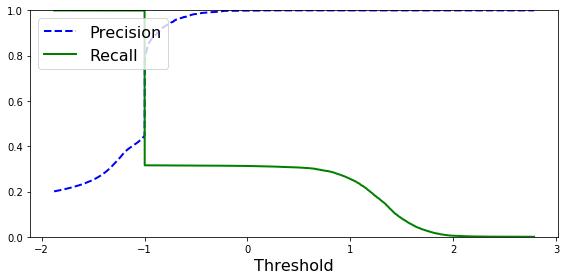

In [79]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
#plt.xlim([-700000, 700000])
save_fig("precision_recall_vs_threshold_plot")
plt.show()

Saving figure precision_vs_recall_plot


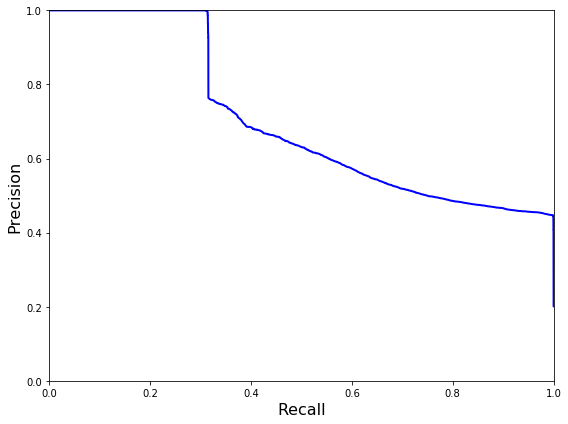

In [80]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
save_fig("precision_vs_recall_plot")
plt.show()

In [81]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

Saving figure roc_curve_plot


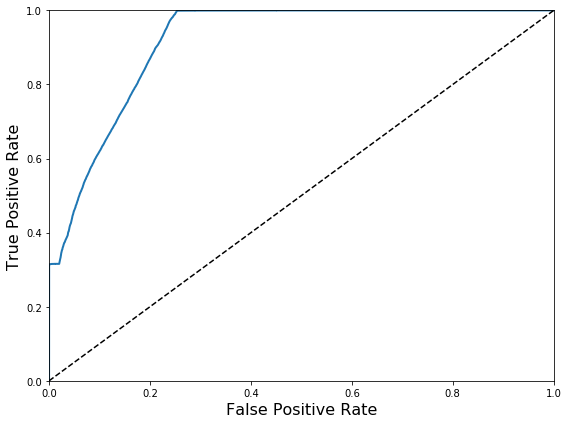

In [82]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
save_fig("roc_curve_plot")
plt.show()

In [83]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.916170944509207

In [90]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

knei = KNeighborsClassifier()
y_probas_knei = cross_val_predict(knei, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [85]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

In [94]:
y_scores_knei = y_probas_knei[:, 1] # score = proba of positive class
fpr_knei, tpr_knei, thresholds_knei = roc_curve(y_train_5,y_scores_knei)

Saving figure roc_curve_comparison_plot


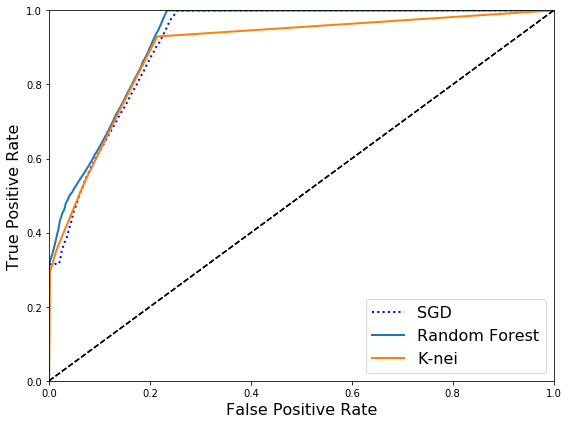

In [95]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plot_roc_curve(fpr_knei, tpr_knei, "K-nei")
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

In [87]:
roc_auc_score(y_train_5, y_scores_forest)

0.9249790341134767

In [88]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.8004667444574096

In [89]:
recall_score(y_train_5, y_train_pred_forest)

0.4361093452002543